<a href="https://colab.research.google.com/github/AvonleaFisher/Analyzing-NYC-311-Service-Requests/blob/main/Exploring_the_Data_Scatterplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this section, we'll create summaries and visualizations to explore the data.

**Note:** Notebooks with exploratory visualizations have been broken up into multiple sections to reduce file size. Dependencies required across all EDA notebooks are imported below. To view animated plots that do not render on GitHub, enter the URL into [Jupyter Notebook Viewer](https://nbviewer.jupyter.org/).

# Loading Dependencies

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk import FreqDist
from nltk.probability import FreqDist
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import random
import plotly.io as pio

 #display plotly figures
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/MyDrive/Colab Notebooks/community_board_311.csv'
df = pd.read_csv(path, index_col=0)

In [18]:
path = '//content/drive/MyDrive/Colab Notebooks/clean_indicators.csv'
ind_df = pd.read_csv(path)

## Visualizing Average Daily Call Volume

### Bubble Chart

Using variables from both datasets, it is possible to calculate the average number of daily calls per square mile in a given community district. We may expect larger community districts to recieve more calls, but dividing the average daily calls by square milage, as the below function does, can account for this relationship. 

In [19]:
def avg_calls_sqmi(df, community_board):

  """Takes in a dataframe and the name of a community board as a string. Returns 
     the average daily number of 311 calls that correspond to the given 
     community board, divided by the community board's area in square miles."""  
     
    
  subset = df[df.community_board == community_board]
    
  area_sqmi = int(subset.area_sqmi[:1])

  call_freqs_by_date = {}
    
  for i in subset.index:
        
      day = subset.day[i]
    
      if day not in call_freqs_by_date: 
          
        call_freqs_by_date[day] = 1
        
      else:
          
        call_freqs_by_date[day] += 1
    
  total = sum(call_freqs_by_date.values())

  length = len(call_freqs_by_date)

  daily_avg = total/length
    
  avg_per_sqmi = daily_avg/area_sqmi

  return avg_per_sqmi

The function is applied to each community board below to create a dataframe with all of the daily averages.

In [20]:
#create empty dictionary
daily_avg_dict_cb = {}

In [21]:
#loop through community boards and update the dictionary with averages
for cboard in df.community_board.unique():
  daily_avg_dict_cb[cboard] = 0
  daily_avg_dict_cb[cboard] += int(avg_calls_sqmi(df, cboard))

In [22]:
#create dataframe from above dict and arrange in descending order of averages 
daily_avg_cb_df = pd.DataFrame.from_dict(daily_avg_dict_cb, orient='index', columns=["Avg daily calls per sqmi"])
daily_avg_cb_df = daily_avg_cb_df.sort_values(by='Avg daily calls per sqmi', ascending=False)

In [23]:
#create community board column in above df to merge with the indicators df
daily_avg_cb_df['community_board'] = daily_avg_cb_df.index
ind_with_avg_calls = pd.merge(ind_df, daily_avg_cb_df, how='inner')

In [24]:
#create borough column to organize visualization by borough
ind_with_avg_calls['Borough'] = [i[2:].strip() for i in ind_with_avg_calls.community_board]

The bubble plot below visualizes the average daily calls per square mile for each community board. The color of the points varies based on borough, while the size varies based on the crime rate per 1000 residents. Larger points indicate a higher crime rate. This feature will allow for the visualization of any relationship between crime rate and daily average call volume.

In [25]:
bubble_fig = px.scatter(ind_with_avg_calls, x="community_board",  
                 y="Avg daily calls per sqmi", color="Borough", height=700,
                 size='crime_per_1000', size_max=90, color_discrete_sequence=[
                                        "lightsalmon", "lightseagreen", 
                                        "lightskyblue", "lightpink", 
                                        "lightslategray"])

bubble_fig.update_layout(hovermode='x',
                  title="Average Daily 311 Calls/Sq Mile",
                  xaxis_title="Community Board",
                  font=dict(family="silom",
                  size=14, color="#58508d", 
                  ))

bubble_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))

bubble_fig.show()

There is no clear relationship between crime rate and daily call volume, but Staten Island—which is the borough with the lowest call volume—also contains districts with some of the lowest crime rates. Manhattan and the Bronx are home to districts with the highest daily call averages.

### Scatterplots

Next, we'll create some scatterplots to examine possible relationships between daily average calls per square mile and other numeric variables in the data. Below, we create two additional numeric variables—the average hour and day of week for a district's calls—and add them to a dataframe with all numeric features.

In [26]:
#dictionary with community districts and average weekday of calls
weekdays = {}

def weekday_df_cb(df, community_board):
    
    subset = df[df.community_board == community_board]
    
    weekday_list = []

    for i in subset.index:
        
        day = subset.day_of_week[i]
          
        weekday_list.append(day)
    
    total = sum(weekday_list)

    length = len(weekday_list)

    avg = total/length
    
    return round(avg, 2)

for cboard in df.community_board.unique():
  weekdays[cboard] = 0
  weekdays[cboard] += weekday_df_cb(df, cboard)

In [27]:
#dictionary with community districts and average hour of calls
hours = {}

def hours_cb(df, community_board):
    
    subset = df[df.community_board == community_board]
    
    hour_list = []

    for i in subset.index:
        
        day = subset.hour[i]
          
        hour_list.append(day)
    
    total = sum(hour_list)

    length = len(hour_list)

    avg = total/length
    
    return round(avg, 2)

for cboard in df.community_board.unique():
  
  hours[cboard] = 0
  
  hours[cboard] += hours_cb(df, cboard)

In [28]:
#merge the average weekday with ind_with_avg_calls
avg_time_week = pd.DataFrame.from_dict(weekdays, orient='index', columns=["avg_time_week"])
avg_time_week['community_board'] = avg_time_week.index

ind_with_avg_calls = pd.merge(ind_with_avg_calls, avg_time_week, how='inner')

In [29]:
#merge the average hour with ind_with_avg_calls
avg_hr = pd.DataFrame.from_dict(hours, orient='index', columns=["avg_hr"])
avg_hr['community_board'] = avg_hr.index

ind_with_avg_calls = pd.merge(ind_with_avg_calls, avg_hr, how='inner')

In [30]:
#create dataframe with relevant features
features = ind_with_avg_calls.drop(['community_board'], axis=1)

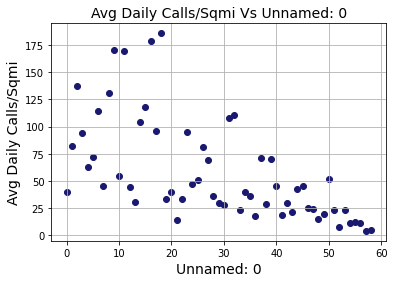

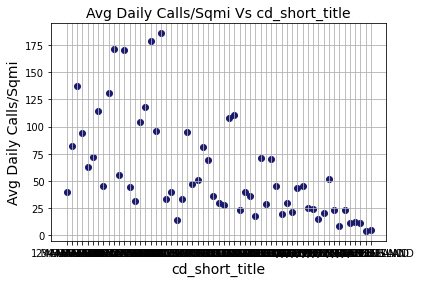

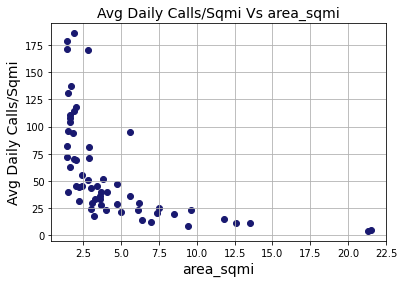

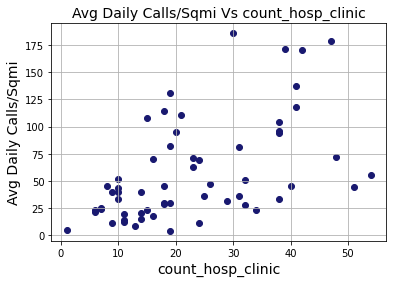

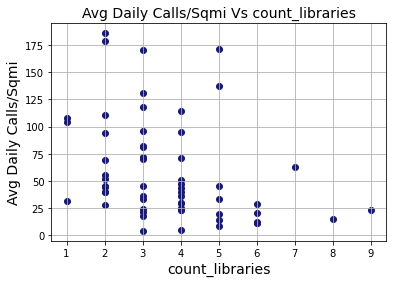

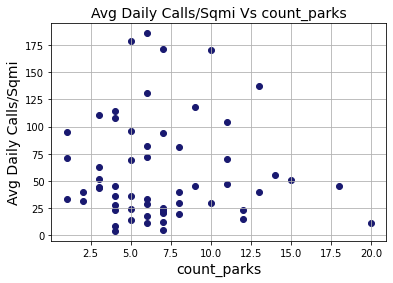

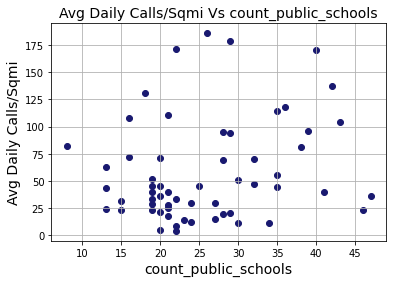

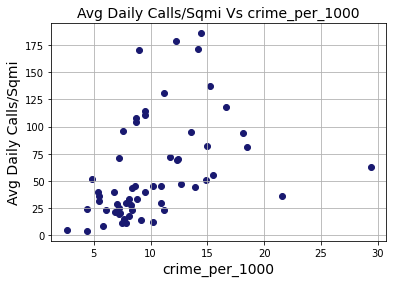

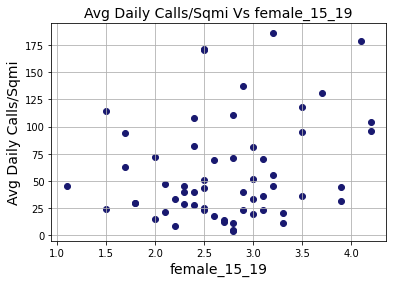

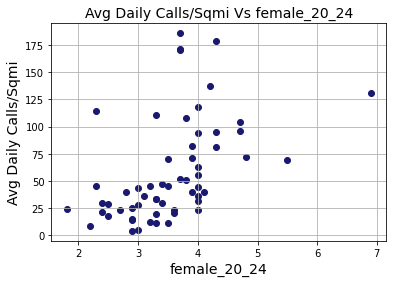

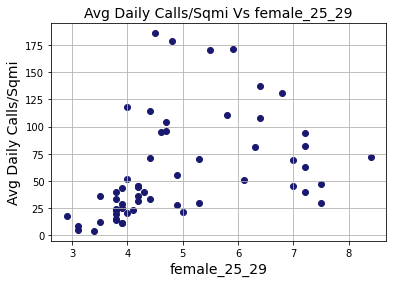

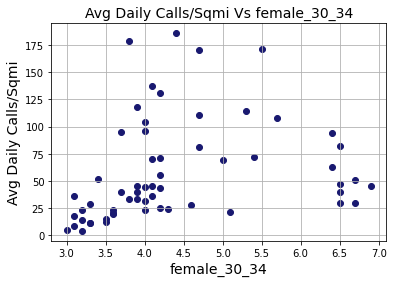

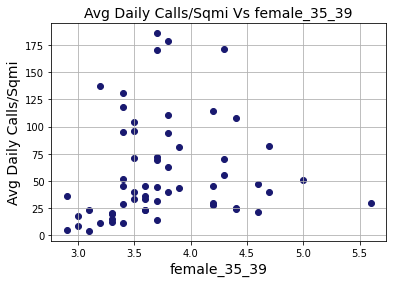

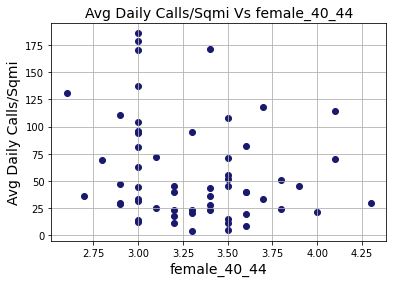

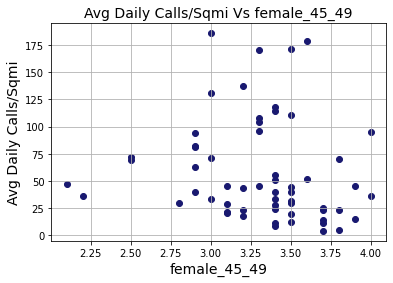

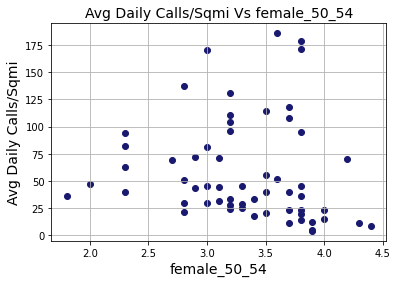

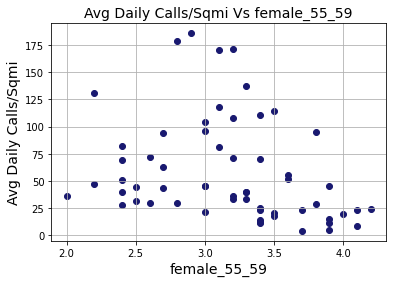

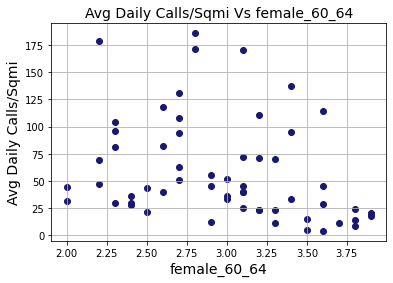

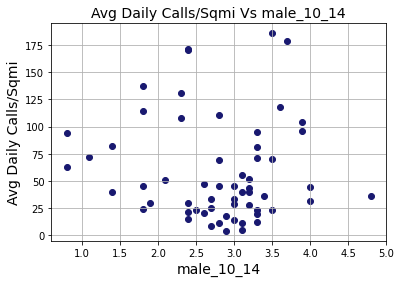

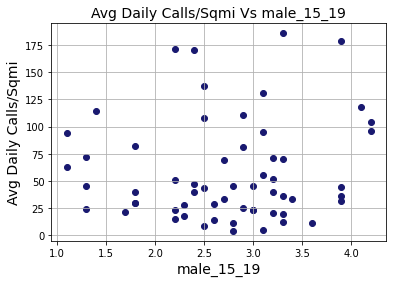

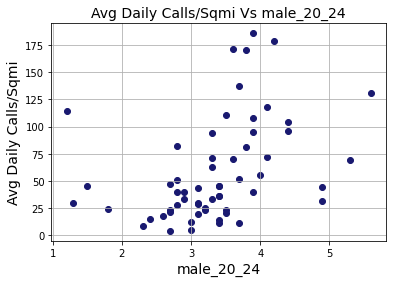

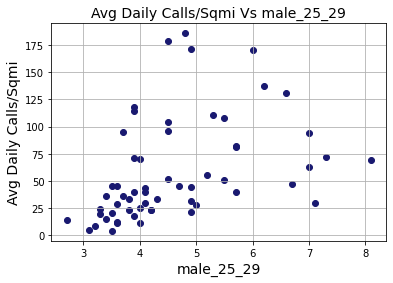

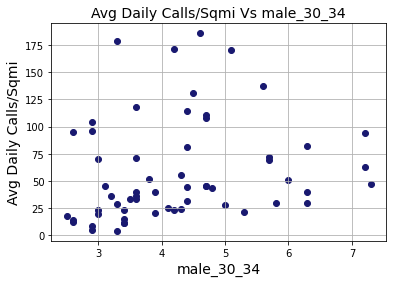

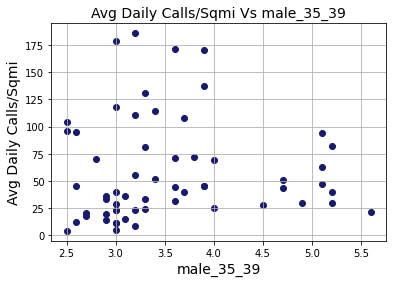

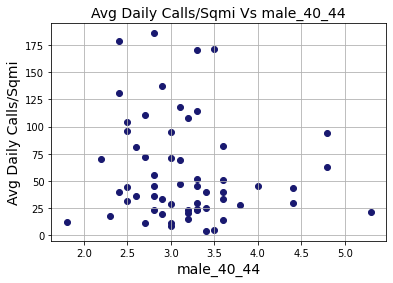

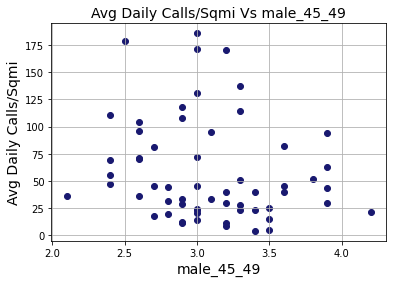

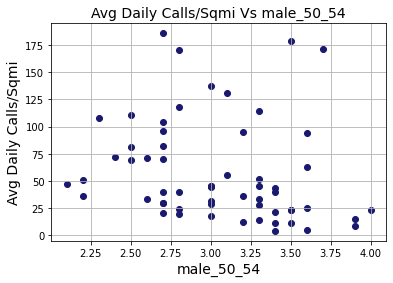

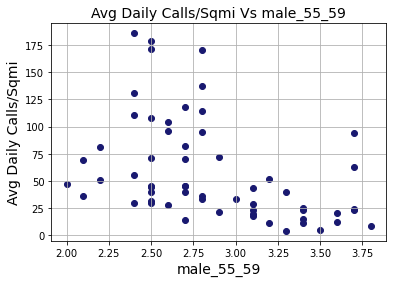

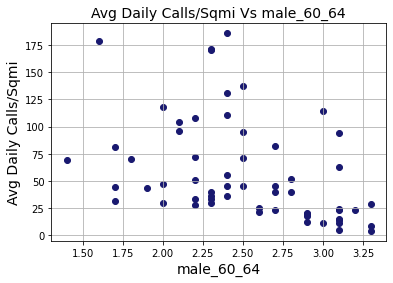

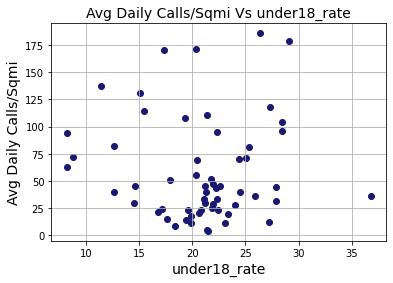

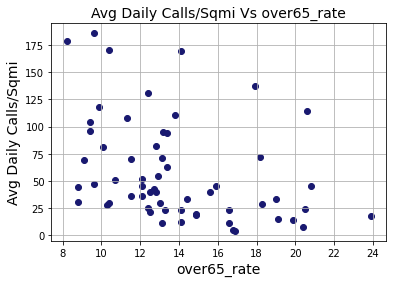

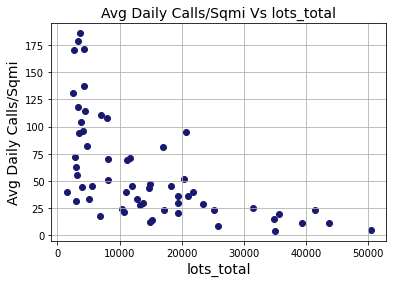

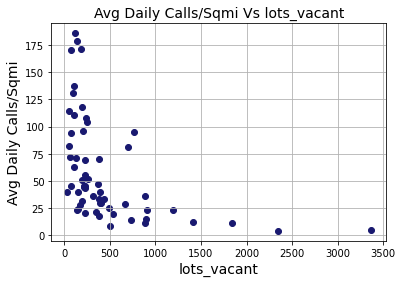

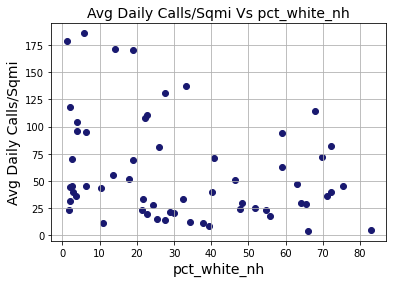

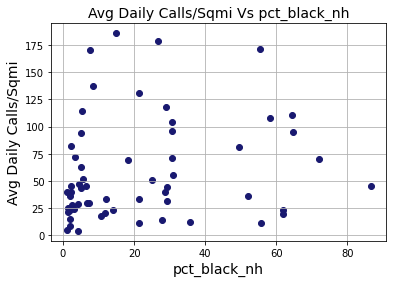

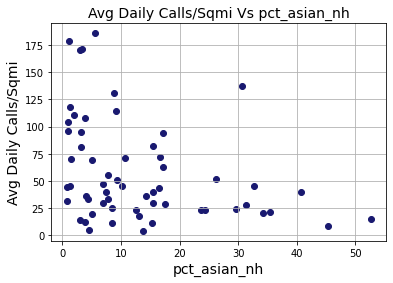

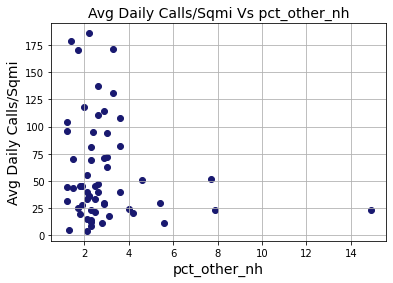

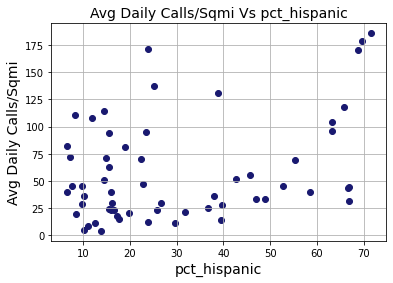

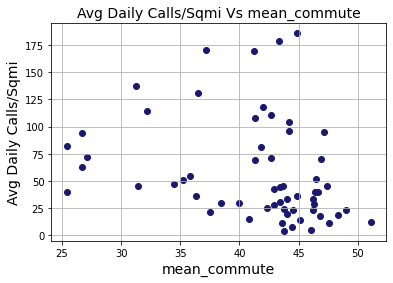

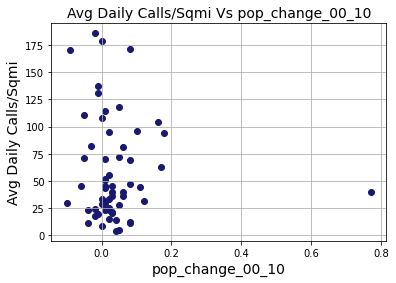

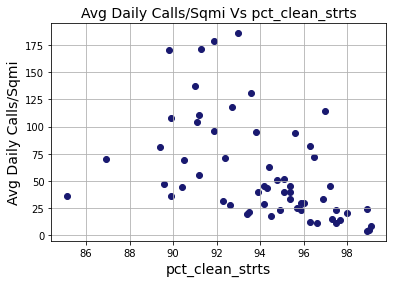

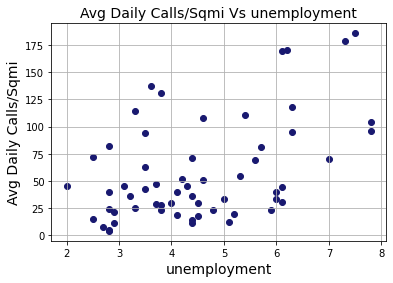

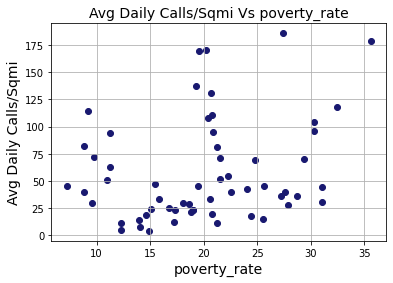

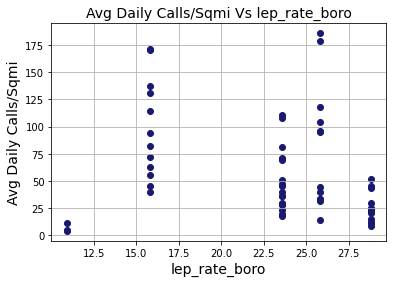

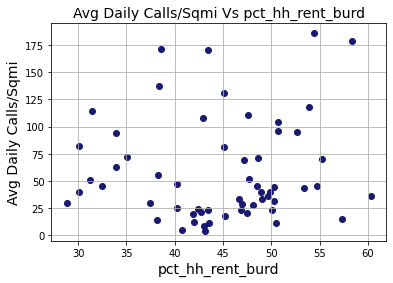

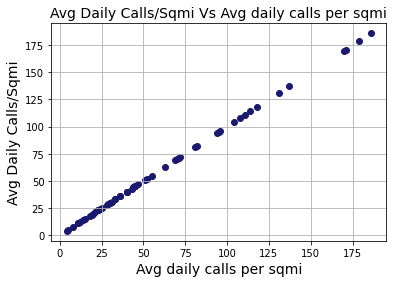

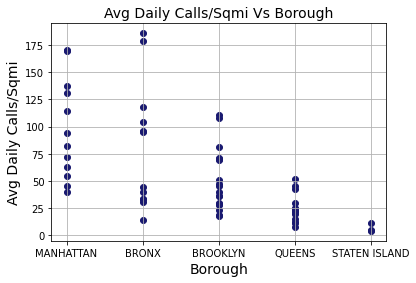

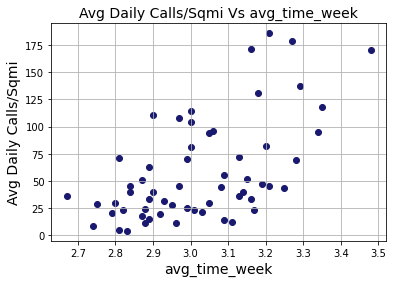

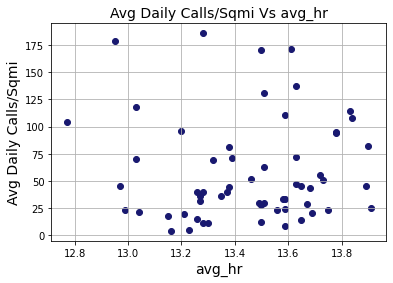

In [31]:
#plot features against avg daily calls per sqmi in scatterplots
for feat in features:
  plt.scatter(features[feat], features['Avg daily calls per sqmi'], color='midnightblue')
  plt.title('Avg Daily Calls/Sqmi Vs {}'.format(str(feat)), fontsize=14)
  plt.xlabel(str(feat), fontsize=14)
  plt.ylabel('Avg Daily Calls/Sqmi', fontsize=14)
  plt.grid(True)
  plt.show()

There is no clear linear relationship between the daily average calls per square mile and other numeric variables for the community districts. These plots nonetheless allow for some interesting observations. The districts with the highest percentage of clean streets, for example, also have the lowest call volume. The majority of districts have fewer than 500 vacant lots, and had a population change of less than .2 between 2000 and 2010. Two districts with a relatively high unemployment rate (around 7.5) have the higest call volume in the unemployment scatterplot. Finally, in the average time of week plot, higher values on the x-axis largely correspond to higher values on the y-axis. This suggests that most calls happen after Tuesday: calls that occur later in the week pull the "average time of week" value upward. 

# References

[Bubble Charts in Python](https://plotly.com/python/bubble-charts/)
